In [ ]:
%pip install -r requirements.txt

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
sns.set_style ("darkgrid")
mean_plot = 3
num = 40

In [7]:
DF_PATH = "./leaf_masking/GRUPO_6/csv/GROUP_6.csv"
df = pd.read_csv(DF_PATH)

VALOR MINIMO:0.7614826353879526
VALOR MAXIMO:1.0


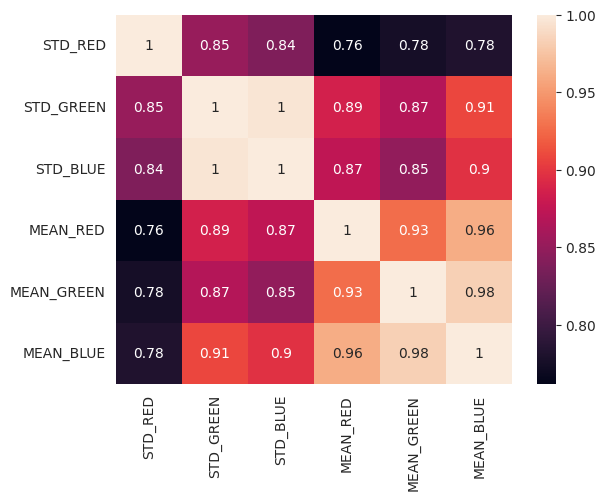

In [31]:
corr : pd.DataFrame = df.drop(['GROUP', 'WATERSHADE_MATRIX', 'Unnamed: 0'], axis = 1).corr()
print(f'VALOR MINIMO:{corr.values.min()}')
print(f'VALOR MAXIMO:{corr.values.max()}')
sns.heatmap(corr, annot=True);

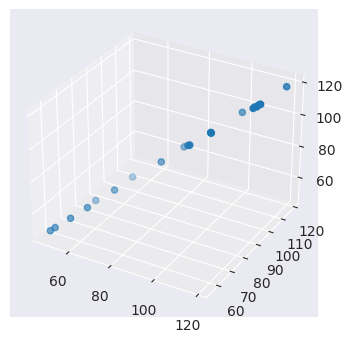

In [22]:
plt.figure(figsize = (5, 4))
plot_axes = plt.axes(projection = '3d')
plot_axes.scatter3D(df['MEAN_BLUE'], df['MEAN_GREEN'], df['MEAN_BLUE'])
plt.show()

In [8]:
df.sample()

,Unnamed: 0,GROUP,STD_RED,STD_GREEN,STD_BLUE,MEAN_RED,MEAN_GREEN,MEAN_BLUE,WATERSHADE_MATRIX
1,1,GRUPO_6,27.636953,34.919322,39.390498,60.145156,94.368331,88.974694,leaf_masking/GRUPO_6/csv/leaf_group_6_2_waters...
